In [11]:
using QuantumOptics
using PyPlot
using Statistics, Distributions, Random
using PhysicalConstants.CODATA2018: c_0, k_B, m_u
using Unitful

using DataFrames
using CSV

using DifferentialEquations
using LinearAlgebra

using SplitApplyCombine

### Atom in dipole trap, choice of constants.

__Potential energy__

$\Pi = U_0 \left(1 - \frac{1}{1+(z/z_0)^2} exp\left(\frac{-2(x^2+y^2+z^2)}{w_0^2(1+(z/z_0)^2)}\right) \right)$


__Kinetic energy__

$K = \frac{m V^2}{2}$


__Total energy__

$E = \Pi + K$



__Constants__

$E = \varepsilon E_0, \;\;\; E_0 = 10\mu K$


$kT = t E_0$ 


$V = v v_0, \;\;\; v_0 = \sqrt{\frac{E_0}{m}}$


$R = r r_0, \;\;\; r_0 = 1\mu m$


__Dimensionless units__


$\Pi =  u_0 E_0 \left(1 - \frac{1}{1+(z/z_0)^2} exp\left(\frac{-2(x^2+y^2+z^2)}{w_0^2(1+(z/z_0)^2)}\right) \right)$


$K = E_0\frac{v^2}{2}$


$p(x,y,z,v_x,v_y,v_z) \sim exp\left(- \frac{u_0}{t}\left(1 - \frac{1}{1+(z/z_0)^2} exp\left(\frac{-2(x^2+y^2+z^2)}{w_0^2(1+(z/z_0)^2)}\right) \right) \right)exp\left(- \frac{v_x^2+v_y^2+v_z^2}{2t} \right)$


Markov Chain Monte Carlo is used to generate initial conditions $(x,y,z,v_x,v_y,v_z)|_{t=0}$

__Harmonic approximation__


For $T\ll U_0$ gaussian potential can be replaced with harmonic one.

$U(x,y,z)=U_0\left( \frac{2(x^2+y^2)}{w_0^2} + \frac{z^2}{z_0^2}\right) = 
\frac{m \omega_r ^2 (x^2+y^2)}{2} + \frac{m \omega_z ^2 (z^2)}{2}$, where 

$\omega_r = \sqrt{\frac{4 U_0}{m w_0^2}} = \frac{2}{w_0} \sqrt{\frac{U_0}{E_0}}\sqrt{\frac{E_0}{m}} = 2 \frac{v_0}{w_0}  \sqrt{u_0}$

$\omega_z = \sqrt{\frac{2 U_0}{m z_0^2}} = \sqrt{2}\frac{v_0}{z_0}  \sqrt{u_0}$.


_In that case atom dynamics is integrable:_

$H = \frac{m \omega_r ^2 (x^2+y^2)}{2} + \frac{m \omega_z ^2 (z^2)}{2} + \frac{m(v_x^2+v_y^2+v_z^2)}{2}$

$x(t)=x_0 \cos(\omega_r t) + \frac{v_{x0}}{\omega_r}\sin(\omega_r t)$,

$y(t)=y_0 \cos(\omega_r t) + \frac{v_{y0}}{\omega_r}\sin(\omega_r t)$,

$z(t)=z_0 \cos(\omega_r t) + \frac{v_{z0}}{\omega_z}\sin(\omega_r t)$

$(x_0,y_0,z_0,v_{x0},v_{y0},v_{z0})$ can be sampled using Monte-Carlo

In [2]:
c = ustrip(u"m/s", c_0);
kB = ustrip(u"J/K", k_B);
mu = ustrip(u"kg", m_u);


m = 86.9091835 * mu; #Rb87 mass
E0 = kB * 10e-6;     #Characteristic energy in μK
v0 = sqrt(E0/m);     #Characteristic velocity in μm/μs
r0 = 1e-6;           #Characteristic distance in m
λ = 0.852;           #Wavelength of dipole trap in μm

w0 = 1.0;            #Beam waist radius in μm
z0 = π*w0^2/λ;       #Beam Rayleigh range in μm
U0 = 100.0;          #Depth of potential in E0(10 μK)


println(c)
println(kB)
println(mu)
println()
println(m)
println(E0)
println(v0)
println(r0)
println()
println(w0)
println(z0)

2.99792458e8
1.380649e-23
1.6605390666e-27

1.4431609444805812e-25
1.3806490000000002e-28
0.03093030892809343
1.0e-6

1.0
3.687315321114781


In [3]:
#params = (U0, w0, z0)
#cord = (x, y, z, vx, vy, vz)
#T - temperature

#Beam radius
function w(z, w0, z0)
    return w0 .* sqrt.(1.0 .+ (z ./z0) .^2)
end;



#Amplitude of gaussian beam with E0 = 1
function A(x, y, z, w0, z0)
    return (w0 ./ w(z, 1.0, z0)) .* exp.(- (x .^2 + y .^2) ./ (w(z, w0, z0) .^2));
end;


#Phase of gaussian beam
function A_phase(x, y, z, w0, z0)
    k = 2.0 * z0 / w0^2;
    return exp.(-1.0im * k * z .* (0.5*(x .^2 + y .^ 2) ./ (z .^2  + z0 .^2)) + 1.0im * atan.(z ./ z0));
end;



function Π(cord, params)
    U0, w0, z0 = params;
    x, y, z, vx, vy, vz = cord;
    
    r2 = x .^2 .+ y .^2;
    return U0 .* (1.0 .- A(x, y, z, w0, z0) .^2);
end;


function Π_Harmonic(cord, params)
    U0, w0, z0 = params;
    x, y, z, vx, vy, vz = cord;
    
    r2 = x .^2 .+ y .^2;
    return U0 .* (2.0*r2 ./w0^2 + (z ./z0).^2);
end;


function K(cord, params)
    U0, w0, z0 = params;
    x, y, z, vx, vy, vz = cord;
    return (vx .^2 + vy .^2 + vz .^2) / 2.0
end;


function E(cord, params; harmonic=false)
    if harmonic
        return Π_Harmonic(cord, params) + K(cord, params)
    else
        return Π(cord, params) + K(cord, params)
    end;
end;


function prob_boltzmann(cord, params, T; harmonic=false)    
    return exp.(-E(cord, params; harmonic) ./ T)
end;

In [4]:
#N - number of samples
#skip - number of skipped samples at start

function boltzmann_samples(params, T, N; step=50.0, freq=1, skip=100, harmonic=false)
    U0, w0, z0 = params;

    mean = zeros(6);
    cov = Diagonal([w0/step, w0/step, z0/step, 2*sqrt(T)/step, 2*sqrt(T)/step, 2*sqrt(T)/step] .^ 2);
    d = MvNormal(mean, cov);
    
    samples = [[0.0, 0.0, 0.0, sqrt(1/3), sqrt(1/3), sqrt(1/3)]];
    u_acc = rand(Uniform(0.0, 1.0), N*freq + skip);
    acc_rate = 0;
    
    for i ∈ 1:N*freq + skip - 1
        cord_last = samples[end];
        cord_new = cord_last + rand(d);
        p_acc = prob_boltzmann(cord_new, params, T; harmonic)/prob_boltzmann(cord_last, params, T; harmonic);
        
        if p_acc > u_acc[i] && E(cord_new, params) < U0
            push!(samples, cord_new);
            acc_rate += 1; 
        else
            push!(samples, cord_last);
        end;
    end;
        
    return samples[1+skip:freq:end], acc_rate/(N*freq + skip)
end;

In [13]:
samples, acc_rate = boltzmann_samples([1000.0, w0, z0], 50.0, 1000; step=4, freq=100, skip=1000);
samples_h, acc_rate_h = boltzmann_samples([1000.0, w0, z0], 50.0, 1000; step=5, freq=100, skip=1000, harmonic=true);
println(acc_rate)
println(acc_rate_h)

0.04675247524752475
0.07831683168316832


In [14]:
x, y, z, vx, vy, vz = invert(samples);
x_h, y_h, z_h, vx_h, vy_h, vz_h = invert(samples_h);

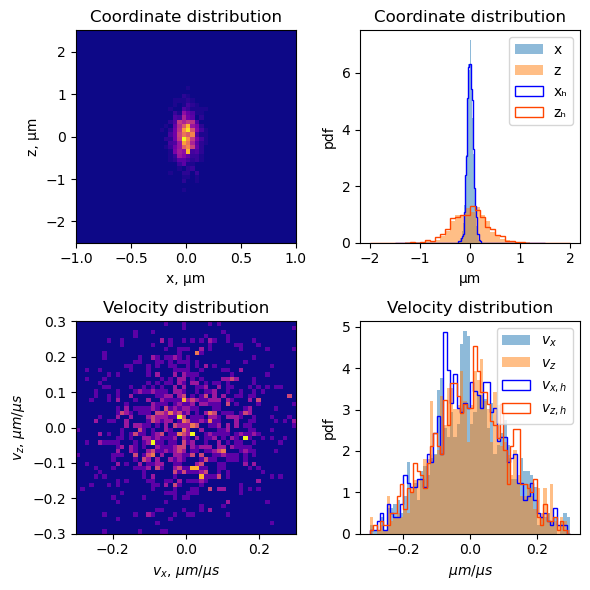

In [15]:
figure(figsize=(6,6))
subplot(221)
hist2D(x, z, bins=50, range=[[-1.0, 1.0], [-2.5, 2.5]],cmap="plasma", rasterized=true);
xlabel("x, μm")
ylabel("z, μm")
title("Coordinate distribution");

subplot(222)
hist(x, bins=[-1.5:0.02:1.5;], density=true, alpha=0.5, label="x")
hist(z, bins=[-2.0:0.1:2.0;], density=true, alpha=0.5, label="z")
hist(x_h, bins=[-1.5:0.02:1.5;], density=true, histtype="step", label="xₕ", color="blue")
hist(z_h, bins=[-2.0:0.1:2.0;], density=true, histtype="step", label="zₕ", color="orangered")
xlabel("μm")
ylabel("pdf")
title("Coordinate distribution");
legend()

subplot(223)
hist2D(vx * v0, vz * v0, bins=50, range=[[-0.3, 0.3], [-0.3, 0.3]],cmap="plasma", rasterized=true);
xlabel("\$ v_x \$, \$ \\mu m/ \\mu s \$")
ylabel("\$ v_z \$, \$ \\mu m/ \\mu s \$")
title("Velocity distribution");


subplot(224)
hist(vx * v0, bins=[-0.3:0.01:0.3;], density=true, alpha=0.5, label="\$ v_x \$")
hist(vz * v0, bins=[-0.3:0.01:0.3;], density=true, alpha=0.5, label="\$ v_z \$")
hist(vx_h * v0, bins=[-0.3:0.01:0.3;], density=true, histtype="step", label="\$ v_{x,h} \$", color="blue")
hist(vz_h * v0, bins=[-0.3:0.01:0.3;], density=true, histtype="step", label="\$ v_{z,h} \$", color="orangered")
xlabel("\$ \\mu m/ \\mu s \$")
ylabel("pdf")
title("Velocity distribution");
legend()

tight_layout()

# savefig("data/atom_distribution.pdf", dpi=300)

In [8]:
#Generate coordinate trajectory from MC initial conditions
function r(t, ri, vi, ω)
    return ri * cos.(ω .* t) + vi/ω * sin.(ω .* t);
end;    


#Generate velocity trajectory from MC initial conditions
function v(t, ri, vi, ω)
    return v0 * vi * cos.(ω .* t) - ri * ω * sin.(ω .* t);
end;        



#Due to atom dynamics
function Ω(x, y, z, Ω0, w0, z0)
    return Ω0 .* A(x, y, z, w0, z0) .* A_phase(x, y, z, w0, z0);
end;


#Due to Doppler shift for red laser
function Δ(vz, w0, z0)
    k = 2 * z0/w0^2;
    return k * vz
end;


#Due to Doppler shifts for red and blue lasers
function δ(vz, wr0, zr0, wb0, zb0)
    kr = 2 * zr0/wr0^2;
    kb = 2 * zb0/wb0^2;
    
    return (kr - kb) * vz
end;

__Two-photon Rydberg Modelling parameters__

- atom temperature $T$


- spontaneous decay rates from intermediate state $\gamma_i$


- trap parameters: $U_0, w_0, z_0$


- excitation beam parameters: $w_R, z_R, n(\text{flat-top param})$


- other excitation beam parameters: $\Omega_R, \Omega_B, \Delta$


- laser phase noise: $S_{\phi,R},S_{\phi,B}$


- laser intensity noise: $\sigma_{I,R}/I, \sigma_{I,B}/I$


- finite-contrast parameters $(\epsilon, \epsilon', \eta)$



__Functions__


- $\Delta(t)$ - AC Stark shifts + Doppler


- $\phi(t)$ - Laser phase noise for red and blue lasers


- $\Omega(t)$ - Rabi frequency due to atom dynamics and laser intensity fluctuations

- if I measure recapture probability $p_{recap}$ from switch-off time $\tau$, I can retrieve dsitribution of atoms over velocities. It seems like $\frac{d}{d\tau}p_{recap}(\tau)$ should give some insight about it.


- $\varepsilon ' \simeq \Gamma_R t_{recap}$, where $t_{recap}=\int_{0}^{\infty} p_{recap}(t)dt$, $\Gamma_R $ - Rydberg lifetime



- recapture probability is modeled using Monte-Carlo modelling with free-flight regime, anti-trapping

__To account for: (model, experiment)__

- Spontaneous emission, (+,-)


- Doppler effect, (+,±)


- Laser phase and intensity noise, (+,-)


- Rabi frequency fluctuations due to atom dynamics, (+,±)


- AC Stark shift due to atom dynamics, (+, +)


- $(\epsilon,\epsilon',\eta)$ - finite contrast, (-, -)

--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------

__To be accounted for:__

- Background loss


- Crosstalk


- Fluctuating magnetic&electric fields


- Blackbody radiation

### Doppler effect in TLS